In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [2]:
#定义变量 
thermal_power_station_strategy=np.zeros(shape=(4,1000)) 
wind_power_station_strategy=np.zeros(shape=(2,1000))
c_wind_speed= np.loadtxt("./data/c_wind_speed_uniform_distribution_(3,25).txt")      
kappa_wind_speed= np.loadtxt("./data/kappa_wind_speed_uniform_distribution_(2,3).txt")  
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(70,5).txt") #时变的需求侧用电需求  阶梯式变化 
thermal_power_station_dual_variable=np.zeros(shape=(4,1000))
wind_power_station_dual_variable=np.zeros(shape=(2,1000))#两个风力发电站中有一个是受到拜占庭攻击的 假设第二个风力发电站是受到攻击的
E=np.loadtxt("6_Network_Topology_Double_Random_Adjacency_Matrix.txt")
thermal_power_station_cost=np.zeros(shape=(1,1000)) #火力发电成本
wind_power_station_cost=np.zeros(shape=(1,1000)) #风力发电成本
sum_cost=np.zeros(shape=(1,1000)) #总发电成本
#thermal_power_station_eta=[0.0375,0.0375,0.0625,0.035]
thermal_power_station_eta=[0.0675,0.0675,0.0925,0.0625]
thermal_power_station_zeta=[2,1.75,1,3]
thermal_power_station_xi=[0,0,0,0]
thermal_power_station_P_min=[50,20,15,10]
thermal_power_station_P_max=[200,120,80,100]
#wind_power_station_varphi=[3,6]
wind_power_station_varphi=[1,6]
wind_power_station_v_in=[3,5]
wind_power_station_v_out=[25,25]
wind_power_station_v_r=[13,15]
wind_power_station_sigma_ue=[5,5]
wind_power_station_sigma_oe=[30,20]
wind_power_station_P_r=[160,160]
wind_power_station_P_min=[0,0]
wind_power_station_P_max=[160,160]
sum_thermal_wind_power_station_strategy=np.zeros(shape=(1,1000))
step_size_primal=1
step_size_dual=3
regularization_parameter=0.001
small_Gaussian_Byzantine_attack=np.loadtxt("./data/small_Gaussian_Byzantine_attack_(-150,5).txt")

In [3]:
#火力，风力发电策略初始化
thermal_power_station_strategy[0][0]=70
thermal_power_station_strategy[1][0]=70
thermal_power_station_strategy[2][0]=70
thermal_power_station_strategy[3][0]=70
wind_power_station_strategy[0][0]=70
wind_power_station_strategy[1][0]=0
#初始总发电策略
sum_thermal_wind_power_station_strategy[0][0]=350
#初始化受到攻击的风力发电站的对偶变量
wind_power_station_dual_variable[1][0]=small_Gaussian_Byzantine_attack[0]

#火力，风力发电对偶初始化
thermal_power_station_dual_variable[0][0]=-70
thermal_power_station_dual_variable[1][0]=-70
thermal_power_station_dual_variable[2][0]=-70
thermal_power_station_dual_variable[3][0]=-70
wind_power_station_dual_variable[0][0]=-70

#安全发电站的初始总发电成本
#火力发电成本
for i in range(0,4):
    thermal_power_station_cost[0][0]=thermal_power_station_cost[0][0]+thermal_power_station_eta[i]*thermal_power_station_strategy[i][0]*thermal_power_station_strategy[i][0]+thermal_power_station_zeta[i]*thermal_power_station_strategy[i][0]
#风力发电成本
for i in range(0,1):
    wind_power_station_cost[0][0]=wind_power_station_cost[0][0]+wind_power_station_varphi[i]*wind_power_station_strategy[i][0]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_r[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][0])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_in[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))
#发电总成本
sum_cost[0][0]=thermal_power_station_cost[0][0]+wind_power_station_cost[0][0]


In [4]:
def Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,thermal_power_station_eta,thermal_power_station_zeta,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual):
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("***************************attack_free_online_decentralized_economic_dispatch*****************************")
    print("相关变量初始值为：")
    for i in range (0,4):
        print("第",(i+1),"个火力发电站的初始计划发电量为:",thermal_power_station_strategy[i][0])
    for i in range (0,2):
        print("第",(i+5),"个风力发电站的初始计划发电量为:",wind_power_station_strategy[i][0])
    print("****************************************************************************")
    for i in range (0,4):
        print("第",(i+1),"个火力发电站的初始对偶变量为:",thermal_power_station_dual_variable[i][0])
    for i in range (0,1):
        print("第",(i+5),"个风力发电站的初始对偶变量为:",wind_power_station_dual_variable[i][0])
    print("****************************************************************************")
    print("第",(6),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[1][0])
    print("****************************************************************************")
    print("安全发电站的初始总发电量:",sum_thermal_wind_power_station_strategy[0][0])
    print("*************************")
    print("需求侧平均用电需求:",d_power_demand[0])
    print("****************************************************************************")
    print("风速分布参数c:",c_wind_speed[0])
    print("****************************************************************************")
    print("风速分布参数kappa:",kappa_wind_speed[0])
    print("****************************************************************************")
    print("安全发电站的总发电成本：", sum_cost[0][0])
    print("****************************************************************************")
    print("原变量迭代步长为:",step_size_primal)
    print("*****************************************************************************")
    print("对偶变量迭代步长为:",step_size_dual)
    print("*****************************************************************************")
    
    #开始迭代
    for k in range(1,1000):
        #发电站更新计划发电量和对偶变量
        #对偶变量 先做梯度上升 再做聚合
        #安全发电站的梯度上升
        dual_variable_intermediate=[] #存放当前迭代中6个用户对对偶变量做完梯度下降后得到的中间值
        for i in range(0,4):
            dual_variable_intermediate.append(thermal_power_station_dual_variable[i][k-1]+step_size_dual*((1/6)*thermal_power_station_strategy[i][k-1]-(1/6)*d_power_demand[k-1]-regularization_parameter*thermal_power_station_dual_variable[i][k-1]))
        for j in range(0,1):
            dual_variable_intermediate.append(wind_power_station_dual_variable[j][k-1]+step_size_dual*((1/6)*wind_power_station_strategy[j][k-1]-(1/6)*d_power_demand[k-1]-regularization_parameter*wind_power_station_dual_variable[j][k-1]))
        #受到攻击的风力发电站的对偶值
        dual_variable_intermediate.append(wind_power_station_dual_variable[1][k-1])
        #聚合 安全的火力发电站的对偶更新
        for i in range(0,4):
            weight_aggregation_dual_variable=0
            for j in range(0,4):
                weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i][j]*dual_variable_intermediate[j]               
            for j in range(0,2):
                weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i][j+4]*dual_variable_intermediate[j+4]
            thermal_power_station_dual_variable[i][k]=weight_aggregation_dual_variable
        #聚合 安全的风力发电站的对偶更新
        for i in range(0,1):
            weight_aggregation_dual_variable=0
            for j in range(0,4):
                weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i+4][j]*dual_variable_intermediate[j]               
            for j in range(0,2):
                weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i+4][j+4]*dual_variable_intermediate[j+4]
            wind_power_station_dual_variable[i][k]=weight_aggregation_dual_variable
        #受到Byzantine攻击的风力发电站的对偶更新
        wind_power_station_dual_variable[1][k]=small_Gaussian_Byzantine_attack[k]          
        
        #安全的火力发电站计划发电量
        for i in range(0,4):
            thermal_power_station_strategy[i][k]=thermal_power_station_strategy[i][k-1]-step_size_primal*(2*thermal_power_station_eta[i]*thermal_power_station_strategy[i][k-1]+thermal_power_station_zeta[i]+(1/6)*thermal_power_station_dual_variable[i][k-1]) 
            if thermal_power_station_strategy[i][k]<=thermal_power_station_P_min[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_min[i]
            elif thermal_power_station_strategy[i][k]>=thermal_power_station_P_max[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_max[i]
        #安全的风力发电站计划发电量
        for i in range(0,1):
            wind_power_station_strategy[i][k]=wind_power_station_strategy[i][k-1]-step_size_primal*(wind_power_station_varphi[i]+wind_power_station_sigma_oe[i]+(wind_power_station_sigma_ue[i]+wind_power_station_sigma_oe[i])*math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(-wind_power_station_sigma_ue[i]-wind_power_station_sigma_oe[i])*math.exp(-(math.pow((wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k-1])/wind_power_station_P_r[i]),kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(1/6)*wind_power_station_dual_variable[i][k-1])
            if wind_power_station_strategy[i][k]<=wind_power_station_P_min[i]:
                wind_power_station_strategy[i][k]=wind_power_station_P_min[i]
            elif wind_power_station_strategy[i][k]>=wind_power_station_P_max[i]:
                wind_power_station_strategy[i][k]=wind_power_station_P_max[i]
        #受到Byzantine攻击的风力发电站的计划发电量
        wind_power_station_strategy[1][k]=wind_power_station_strategy[1][k-1]
        
        #安全发电站的计算总计划发电
        #火力发电量
        for i in range(0,4):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+thermal_power_station_strategy[i][k]
        #风力发电量
        for i in range(0,1):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+wind_power_station_strategy[i][k]
        
        #安全发电站的计算总发电成本
        #火力发电成本
        for i in range(0,4):
            thermal_power_station_cost[0][k]=thermal_power_station_cost[0][k]+thermal_power_station_eta[i]*thermal_power_station_strategy[i][k]*thermal_power_station_strategy[i][k]+thermal_power_station_zeta[i]*thermal_power_station_strategy[i][k]
        #风力发电成本
        for i in range(0,1):
            wind_power_station_cost[0][k]=wind_power_station_cost[0][k]+wind_power_station_varphi[i]*wind_power_station_strategy[i][k]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_r[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][k])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_in[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))
        #发电总成本
        sum_cost[0][k]=thermal_power_station_cost[0][k]+wind_power_station_cost[0][k]
        
        #输出第k次迭代中的结果 每间隔10次迭代输出一次结果
        #if (k+1)%10==0:
        print(k,"次迭代中的结果：")
        for i in range (0,4):
            print("第",(i+1),"个火力发电站的计划发电量为:",thermal_power_station_strategy[i][k])
        for i in range (0,2):
            print("第",(i+5),"个风力发电站的计划发电量为:",wind_power_station_strategy[i][k])
        print("****************************************************************************")
        for i in range (0,4):
            print("第",(i+1),"个火力发电站的对偶变量为:",thermal_power_station_dual_variable[i][k])
        for i in range (0,1):
            print("第",(i+5),"个风力发电站的对偶变量为:",wind_power_station_dual_variable[i][k])
        print("****************************************************************************")
        print("第",(6),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[1][k])
        print("****************************************************************************")
        print("安全发电站的总发电量:",sum_thermal_wind_power_station_strategy[0][k])
        print("*************************")
        print("需求侧平均用电需求:",d_power_demand[k])
        print("****************************************************************************")
        print("风速分布参数c:",c_wind_speed[k])
        print("****************************************************************************")
        print("风速分布参数kappa:",kappa_wind_speed[k])
        print("****************************************************************************")        
        print("安全发电站的总发电成本：", sum_cost[0][k])
        print("****************************************************************************")
        print("原变量迭代步长为:",step_size_primal)
        print("****************************************************************************")
        print("对偶变量迭代步长为:",step_size_dual)
        print("****************************************************************************")
        
        #step_size_primal=(pow(k+1,0.1))
        #step_size_dual=1/(pow(k+1,0.7))#我们发现在在线算法中 不能使用太小的对偶步长 不然后续算法对在线变化会不敏感 
        
        '''#尝试使用两阶段的步长
        if k<=500:
            step_size_dual=1/(pow(k+1,0.7))
        else:
            step_size_dual=0.1'''

    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])
    return None  

In [5]:
Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,thermal_power_station_eta,thermal_power_station_zeta,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual)

***************************attack_free_online_decentralized_economic_dispatch*****************************
相关变量初始值为：
第 1 个火力发电站的初始计划发电量为: 70.0
第 2 个火力发电站的初始计划发电量为: 70.0
第 3 个火力发电站的初始计划发电量为: 70.0
第 4 个火力发电站的初始计划发电量为: 70.0
第 5 个风力发电站的初始计划发电量为: 70.0
第 6 个风力发电站的初始计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的初始对偶变量为: -70.0
第 2 个火力发电站的初始对偶变量为: -70.0
第 3 个火力发电站的初始对偶变量为: -70.0
第 4 个火力发电站的初始对偶变量为: -70.0
第 5 个风力发电站的初始对偶变量为: -70.0
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -149.59297205
****************************************************************************
安全发电站的初始总发电量: 350.0
*************************
需求侧平均用电需求: 72.62781256
****************************************************************************
风速分布参数c: 8.301041
****************************************************************************
风速分布参数kappa: 2.66836324
*******************************************************

In [6]:
#数据存储
np.savetxt('./data/01_small_Gaussian_Byzantine_attack_sum_cost.txt',sum_cost,fmt='%0.8f')
np.savetxt('./data/01_small_Gaussian_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt',sum_thermal_wind_power_station_strategy,fmt='%0.8f')

In [7]:
#评价指标：动态regret和累计的约束违反

In [8]:
#动态regret

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [10]:
sum_cost=np.loadtxt("./data/01_small_Gaussian_Byzantine_attack_sum_cost.txt")
optimal_sum_cost=np.loadtxt("./data/00_optimal_sum_cost_varying_D_c_kappa_normal_distribution_(70,5).txt")

In [11]:
dynamic_regret=[]
dynamic_regret_T=[]
for T in range(1, 1000):
    dynamic_regret_auxiliary_variable=0
    for t in range(0, T):
        dynamic_regret_auxiliary_variable=dynamic_regret_auxiliary_variable+sum_cost[t+1]-optimal_sum_cost[t+1]
    dynamic_regret.append(dynamic_regret_auxiliary_variable)
    dynamic_regret_T.append((dynamic_regret_auxiliary_variable)/T)

In [12]:
dynamic_regret

[430.6414073699998,
 484.6756921699998,
 739.7487982099997,
 1407.1868225699995,
 2219.01963315,
 3461.67898105,
 4745.56830387,
 8126.5622256999995,
 9761.50338198,
 11729.97464468,
 12902.69825764,
 14694.964613030003,
 16139.285907390002,
 17429.3498781,
 19052.231925620003,
 20312.96565882,
 21440.93032557,
 23166.80525267,
 24378.87409152,
 25248.665947809997,
 26083.07713256,
 27402.75139903,
 28172.609887180002,
 29035.500588180003,
 30382.18777892,
 31044.634072080004,
 31705.804284630005,
 33022.486317760005,
 34392.0341648,
 36235.197298,
 37908.39963789,
 39143.60817134,
 40576.94576233,
 42030.439977559996,
 44440.131158469994,
 45986.656995909994,
 47261.30229040999,
 49320.26368798,
 50912.52941303999,
 52366.65790819999,
 53479.08970771999,
 54223.120605209995,
 55835.975807689996,
 56727.28354592,
 57734.777788909996,
 58888.3828935,
 60854.15129691,
 61940.19231775,
 62871.13026535999,
 64149.324239869995,
 65578.94369501999,
 66814.75682226999,
 68182.77825916,
 69314

In [13]:
#绘图 dynamic_regret和dynamic_regret_T

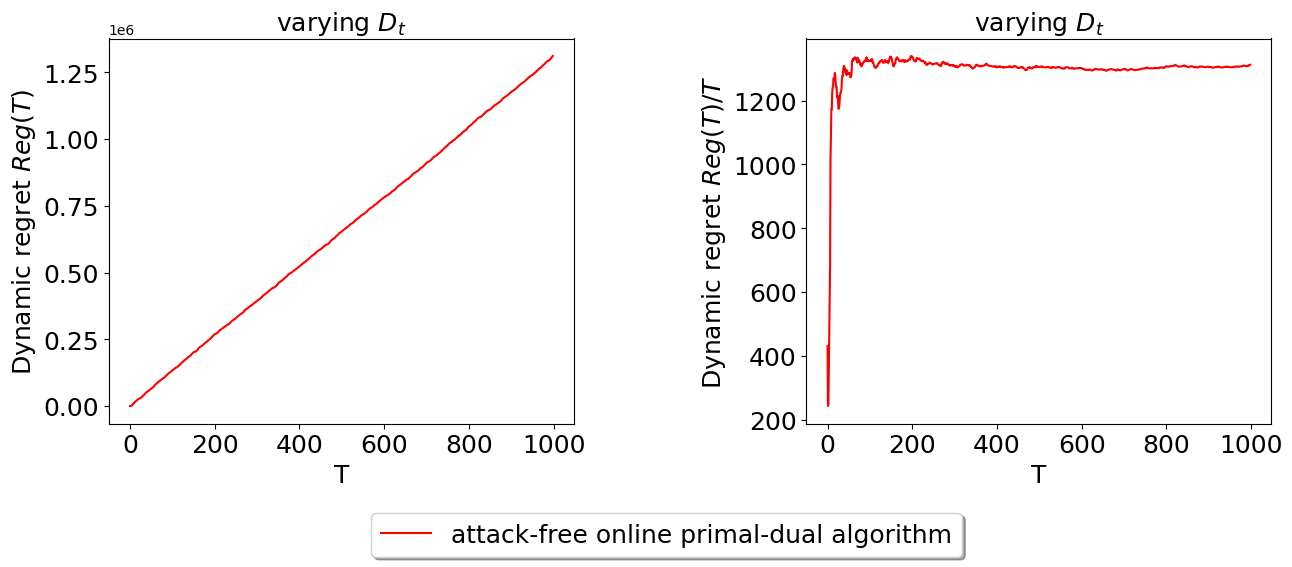

In [14]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret,color = 'red',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret_T,color = 'red',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))

#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.png',format='png', bbox_inches='tight')

In [15]:
#累计的约束违反

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [17]:
sum_thermal_wind_power_station_strategy=np.loadtxt("./data/01_small_Gaussian_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt")
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(70,5).txt")

In [18]:
accumulative_constraint_violation=[]
accumulative_constraint_violation_T=[]
for T in range(1, 1000):
    accumulative_constraint_violation_auxiliary_variable=0
    for t in range(0, T): 
        accumulative_constraint_violation_auxiliary_variable=accumulative_constraint_violation_auxiliary_variable+(1/5)*sum_thermal_wind_power_station_strategy[t+1]-d_power_demand[t+1]
    accumulative_constraint_violation.append(abs(accumulative_constraint_violation_auxiliary_variable))
    accumulative_constraint_violation_T.append(abs(accumulative_constraint_violation_auxiliary_variable)/T)

In [19]:
accumulative_constraint_violation

[5.161334969999999,
 4.862004577999997,
 5.9799533519999954,
 12.274657711999993,
 25.087132229999995,
 41.544709901999994,
 61.386904267999995,
 90.839964142,
 116.48713375800001,
 126.49449147600001,
 141.79676105800002,
 170.756843022,
 193.355746114,
 212.78597748200002,
 238.70235743400005,
 258.525438058,
 270.792827388,
 281.481630502,
 300.9382511719999,
 310.8423693619999,
 318.5392852459999,
 327.9941505419999,
 335.83828308199986,
 340.5151794999999,
 358.8691699019999,
 365.4446846679999,
 372.16533799999996,
 390.868900002,
 407.50281757199997,
 431.40165207999996,
 456.86870157,
 468.67813577400005,
 489.564536142,
 510.13961285000005,
 537.8539264400001,
 560.2365823160002,
 579.3284487940002,
 614.3874317740002,
 636.7612552060002,
 651.3812439520002,
 666.2116823920002,
 669.7688265140001,
 679.9125139380001,
 693.2834560020001,
 706.2263263780001,
 722.4637261080001,
 735.1426838540001,
 750.3249423380001,
 759.1821234300002,
 771.6424923040001,
 786.4241451520002,
 7

In [20]:
#绘图 accumulative_constraint_violation和accumulative_constraint_violation_T

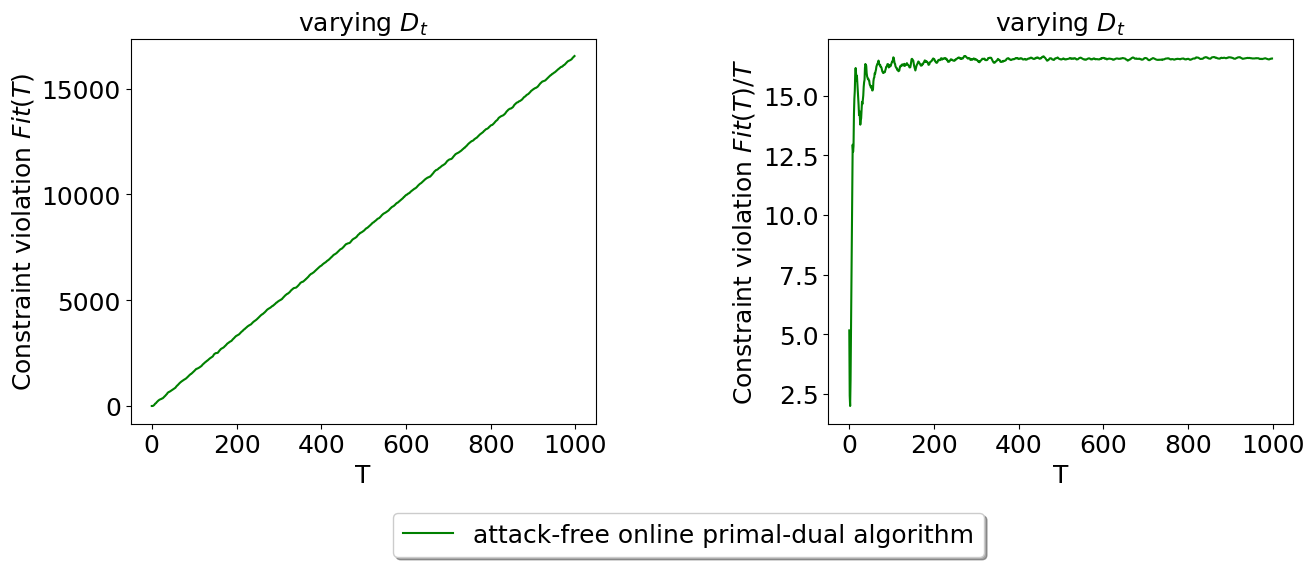

In [21]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation_T,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))


#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.png',format='png', bbox_inches='tight')